## Introdução

Olá, Cientista de Dados! Estamos chegando quase no fim do nosso curso, então vamos fazer a preparação para o que vem por aí!

Durante nosso aprendizado de Visualização de Dados, utilizamos conjuntos de dados que são armazenados em arquivos, do tipo CSV ou JSON (os mais populares), ou ainda modelos mais avançados como PARQUET.

Mas quando o volume de dados cresce exponencialmente ou você está em um ambiente corporativo, é necessário saber manipular bancos de dados. Bancos de dados são uma tecnologia incrível, que nos permite armazenar nossos dados de maneira simples e segura, distribuída e que nos permite, quando bem configurado, recuperar essa informação muito rapidamente. 

O que torna os bancos de dados tão interessantes de usar é a linguagem SQL, que nos permite armazenar e recuperar informações de maneira estruturada e eficente. A linguagem SQL é tão importante para o ecossistema de bancos de dados, que ela já está integrada a maior parte das outras linguagens de programação, seja através de bibliotecas que permitem executar instruções SQL a partir de códigos C#, Java, Python e assim por diante, ou através de integrações mais profundas, como alternar entre SQL e Python em um Jupyter notebook.

E mesmo após esse texto motivacional, você deve estar se perguntando: o que vou fazer com esse conhecimento, se não entendo nada de banco de dados? Então, essa aula pode ser pulada sem problema por agora, mas é aconselhável que você volte assim que aprender mais sobre bancos de dados.

E se você já conhece o básico, continue aqui com a gente!

## Problema

Imagine a seguinte situação: você tem um arquivo realmente grande, com vários milhões de linhas, que você precisa carregar em um DataFrame pandas para fazer algumas análises. Ao tentar carregar o arquivo utilizando o método tradicional do pandas, usando a função `read_csv()`, tudo parece estar funcionando normal, mas após executar algumas operações, seu notebook começa a reclamar de falta de memória para processar os dados.

Porque isso aconteceu? Isso é uma dos poucos problemas de pandas, cada transformação que fazemos em pandas normalmente gera um novo DataFrame, o que vai consumindo cada vez mais memória. Existe no próprio pandas uma maneira de resolver isso: muitas funções tem um parâmetro `inplace` que quando setamos o valor para `True`, ele altera o DataFrame corrente. 

Seguindo o nosso cenário, adicionamos o parâmetro em algumas de nossas transformações e realmente a utilização da memória se reduz significativamente. No entanto, ao conseguirmos rodar toda a rotina, percebemos que ela está com uma performance bem ruim.

Neste caso, podemos tentar outras alternativas, como trocar pandas por Polars, que é outra biblioteca de manipulação e transformação de dados, ou utilizar bancos de dados.

## Passo a Passo

Existem duas maneiras de se trabalhar com bancos de dados no nosso cenário: 
- Carregamos todos os dados em banco de dados, e partir daí:
  - Fazemos todas as análises utilizando uma ferramenta de SQL ou algo similar
  - Fazemos as análises misturando SQL e outra linguagem de programação, tanto em um script/programa ou em um notebook.

Nesta última aula, iremos abordar como utilizar SQL em conjunto com Python em nossos notebooks no Google Colab.

### Passo 1 - Importar as bibliotecas que iremos utilizar

In [9]:
import pandas as pd
import os
import duckdb

%reload_ext sql

Temos duas novidades: estamos importando uma nova biblioteca, chamada `duckdb`, que nos permitirá criar um banco de dados otimizado para análises. Você pode utilizar qualquer banco de dados.

A outra novidade é o comando `%reload_ext sql`. Esse comando carrega no contexto do notebook as bibliotecas `jupysql` e `SqlAlchemy` que nos permitem conectar a diversos bancos de dados e escrever SQL direto no notebook.

Também temos mais algumas configurações que precisam ser feitas:

In [10]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

### Passo 2 - Iniciar um novo banco de dados

In [3]:
if os.path.exists('./db.duckdb'):
  print('Este banco de dados já foi criado, vamos apaga-lo!')
  os.remove('./db.duckdb')

In [11]:
%sql duckdb:///db.duckdb

Aqui também temos uma novidade: estamos criando um novo banco de dados, indicando na conexão que é do tipo duckdb. Este banco será criado na pasta onde estou executando, no meu computador local, ou no caso do Google Colab, na pasta padrão de arquivos (content).

### Passo 3 - Carregar os dados


Para isso, utilizamos a sintaxe `%sql` que nos permite utilizar uma linha de comando SQL em meio a código Python, como na situação abaixo:

In [19]:
table_name = 'test_tbl2'
file_name = 'teste.txt'

%sql create table {table_name} as select * from read_csv_auto('{file_name}')

,Count
0,2


O código acima cria uma tabela no banco de dados com o conteúdo arquivo que foi referenciado. Ao final, mostra a contagem de linhas que foram carregadas.

Quando queremos usar apenas SQL na célula, podemos utilizar o `%%sql`:

In [15]:
%%sql
select * 
from test_tbl

,c1,c2
0,1,'test'
1,2,'test2'


Agora, depois desta pequena demonstração, vamos ao nosso exemplo mais real: vamos carregar os nossos dados em uma tabela no banco de dados, realizar uma SQL query para extrair da tabela apenas as linhas que interessam para nossa análise, e então, fazer a plotagem dos dados.

### Passo 4 - Vendo um exemplo do início ao fim

In [21]:
# Código para baixar um arquivo da internet
import requests as r # importa a biblioteca de manipulação de requests

# faz uma chamada para um arquivo texto que está na internet
conteudo_arquivo = r.get('https://github.com/labeduc/datasets/blob/main/pokemons/all.csv?raw=true')

# Grava o conteúdo que foi baixado em um arquivo local
with open('pokemons.csv', 'w', encoding='utf-8') as fw:
    fw.write(conteudo_arquivo.text)

In [22]:
# Carregando dados no arquivo.
%sql create table pokemons as select * from read_csv_auto('pokemons.csv')

,Count
0,1032


In [23]:
# Agora precisamos trazer o resultado da media de ataque por geração de pokemon

%sql pokemons_agg << SELECT Generation, AVG(Att) as AvgAtt FROM pokemons group by Generation

In [24]:
pokemons_agg

,Generation,AvgAtt
0,1.0,72.913907
1,6.0,95.879699
2,7.0,86.112069
3,8.0,83.417391
4,2.0,68.260000
5,3.0,74.021739
6,4.0,79.991379
7,5.0,82.447853


E a partir daqui, podemos começar a plotar nosso gráfico.

<Axes: xlabel='Generation', ylabel='AvgAtt'>

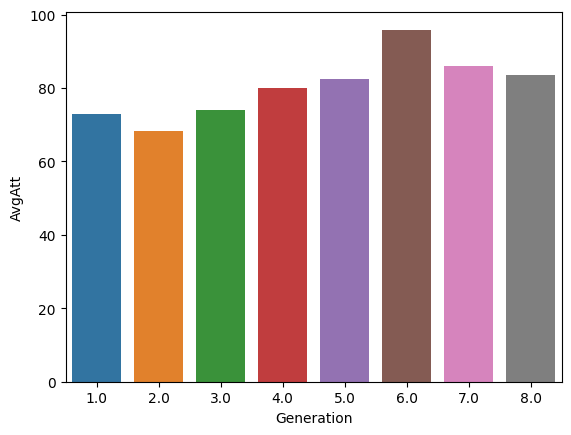

In [25]:
import seaborn as sns


sns.barplot(pokemons_agg, x='Generation',  y='AvgAtt')

### Passo 5 - Fechando a conexão

In [26]:
%sql --conn --close

## Conclusão

Nesta aula, conseguimos aprender como podemos integrar bancos de dados em nossos notebooks para tirar vantagem de sua grande capacidade de armazenamento e da linguagem SQL para realizar transformações nos dados e gerar nossos DataFrames.

Separamos alguns links para você se familiarizar mais com o assunto de bancos de dados:
- Documentação [DuckDb](https://duckdb.org/docs/)
- Porque usar DuckDb? [Leia aqui uma resposta](https://duckdb.org/why_duckdb)
- [Rodando SQL em Jupyter notebooks-usando JUPYSQL (com duckdb e mysql)](https://medium.com/towards-data-science/running-sql-queries-in-jupyter-notebook-using-jupysql-duckdb-and-mysql-3c53fbe40f8d)